In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings
warnings.simplefilter("ignore")

In [4]:
df =pd.read_csv('/kaggle/input/loan-approval-classification-data/loan_data.csv')

In [5]:
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


***Data Exploration***

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [7]:
df.duplicated().sum()

0

In [8]:
df.isna().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

***Preprocessing***

In [9]:
numeric_columns=df.select_dtypes(include=['number']).columns
numeric_columns

Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'loan_status'],
      dtype='object')

remove outliers

In [10]:
def outliers_handler(real_data:pd.DataFrame(),col_name:str)->pd.DataFrame():
    data=real_data.copy()
    q1 = np.percentile(data[col_name],25)
    q3 = np.percentile(data[col_name],75)
    iqr = q3-q1
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)
    outliers = (data[col_name]>upper_bound) | (data[col_name]<lower_bound)
    num_of_outliers = len(data[outliers])
    if num_of_outliers <= len(data)*0.1:
        data = data[~outliers]
        print("Outliers dropped")
    else:
        data.loc[data[col_name]>upper_bound,col_name] = upper_bound
        data.loc[data[col_name]<lower_bound,col_name] = lower_bound
        print("Outliers replaced")
    return data
for i in numeric_columns:
    if i=='loan_status':
        break
    df=outliers_handler(df,i)

Outliers dropped
Outliers dropped
Outliers dropped
Outliers dropped
Outliers dropped
Outliers dropped
Outliers dropped
Outliers dropped


In [11]:
#shape after remove outliers
df.shape[0]

36065

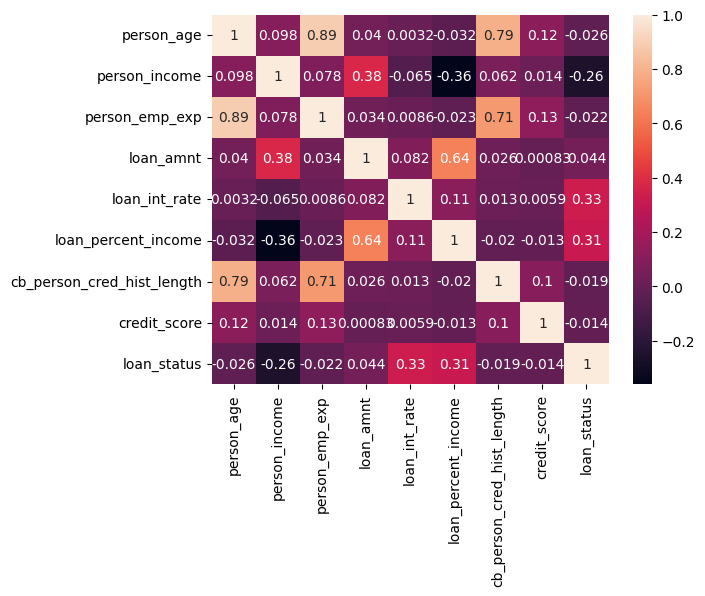

In [12]:
sns.heatmap(df.corr(numeric_only=True),annot=True)
plt.show()

***EDA & INSIGHTS***

In [13]:
df['person_age'].agg(['min','mean','max'])

min     20.000000
mean    26.404631
max     39.000000
Name: person_age, dtype: float64

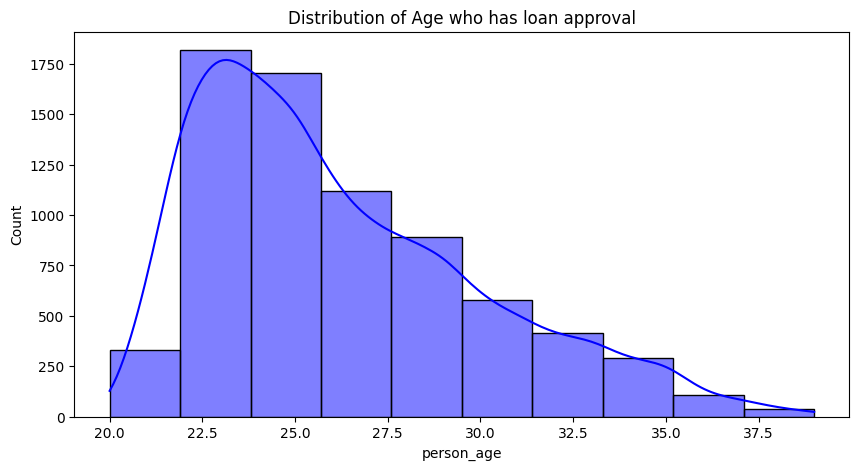

In [14]:
plt.figure(figsize=(10, 5))
sns.histplot(df['person_age'][df['loan_status'] == 1], bins=10, kde=True, color="blue")
plt.title('Distribution of Age who has loan approval')
plt.show()

In [15]:
gender=df['person_gender'].value_counts()
gender

person_gender
male      19742
female    16323
Name: count, dtype: int64

In [16]:
val=df['person_gender'][df['loan_status']==1].value_counts().values
index=df['person_gender'][df['loan_status']==1].value_counts().index
fig = px.pie(values=val,names=index,template='plotly_dark',title='Is Gender affect on loan approval ?').update_traces(textinfo='label+percent')
fig.show()

In [17]:
education=df['person_education'].value_counts()

In [18]:
fig = px.bar(df['person_education'][df['loan_status'] == 1].value_counts(),
             color = df['person_education'][df['loan_status'] == 1].value_counts().index,
             template = 'plotly_dark',
             title = 'Most Education who have loan approval',
             labels = {'value':'Count'},
             text_auto = True
             )
pio.renderers.default = 'iframe'
fig.show()

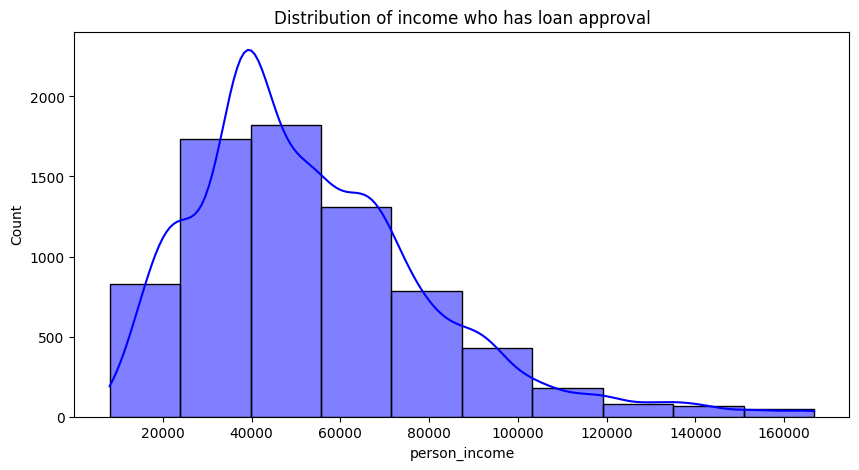

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(df['person_income'][df['loan_status'] == 1], bins=10, kde=True, color="blue")
plt.title('Distribution of income who has loan approval')
plt.show()

In [20]:
owner=df['person_home_ownership'].value_counts()

In [21]:
fig = px.bar(df['person_home_ownership'][df['loan_status'] == 1].value_counts(),
             color = df['person_home_ownership'][df['loan_status'] == 1].value_counts().index,
             template = 'plotly_dark',
             title = 'Most person homeownership who have loan approval',
             labels = {'value':'Count'},
             text_auto = True
             )
pio.renderers.default = 'iframe'
fig.show()

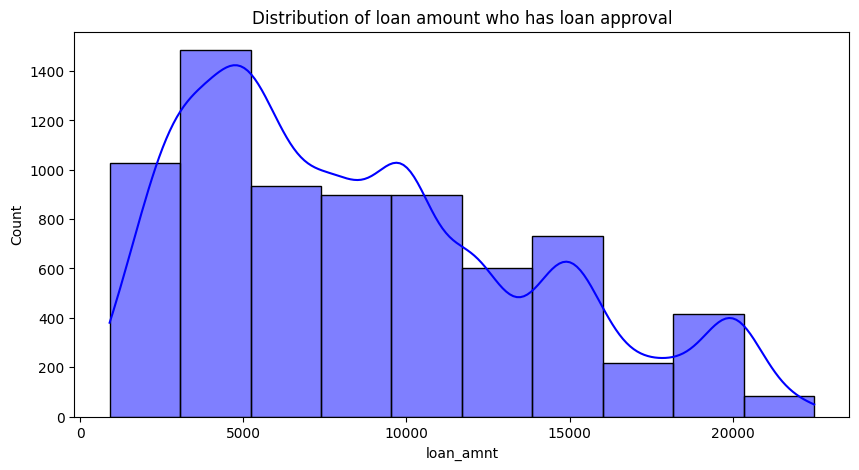

In [22]:
plt.figure(figsize=(10, 5))
sns.histplot(df['loan_amnt'][df['loan_status'] == 1], bins=10, kde=True, color="blue")
plt.title('Distribution of loan amount who has loan approval')
plt.show()

In [23]:
loan_intent=df['loan_intent'].value_counts()

In [24]:
fig = px.bar(df['loan_intent'][df['loan_status'] == 1].value_counts(),
             color = df['loan_intent'][df['loan_status'] == 1].value_counts().index,
             template = 'plotly_dark',
             title = 'Most loan intent who have loan approval',
             labels = {'value':'Count'},
             text_auto = True
             )
pio.renderers.default = 'iframe'
fig.show()

In [25]:
fig = px.bar(df['loan_status'].value_counts(),
             color = df['loan_status'].value_counts().index,
             template = 'plotly_dark',
             title = 'loan status',
             labels = {'value':'Count'},
             text_auto = True
             )
pio.renderers.default = 'iframe'
fig.show()

***Encoding Categorical Columns***

In [26]:
categorical_columns=df.select_dtypes(include=['object'])
categorical_columns

,person_gender,person_education,person_home_ownership,loan_intent,previous_loan_defaults_on_file
1,female,High School,OWN,EDUCATION,Yes
5,female,High School,OWN,VENTURE,No
9,female,High School,OWN,VENTURE,No
19,female,Master,MORTGAGE,EDUCATION,No
23,female,Bachelor,OWN,PERSONAL,Yes
...,...,...,...,...,...
44990,male,Master,RENT,PERSONAL,No
44993,female,High School,RENT,PERSONAL,No
44995,male,Associate,RENT,MEDICAL,No
44997,male,Associate,RENT,DEBTCONSOLIDATION,No


In [27]:
for col in categorical_columns:
    ohe=pd.get_dummies(df[col],dtype=int)
    df=pd.concat([df,ohe],axis=1)
df.drop(categorical_columns,axis=1,inplace=True)

In [28]:
df

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,female,...,OWN,RENT,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE,No,Yes
1,21.0,12282.0,0,1000.0,11.14,0.08,2.0,504,0,1,...,1,0,0,1,0,0,0,0,0,1
5,21.0,12951.0,0,2500.0,7.14,0.19,2.0,532,1,1,...,1,0,0,0,0,0,0,1,1,0
9,21.0,12739.0,0,1600.0,14.74,0.13,3.0,640,1,1,...,1,0,0,0,0,0,0,1,1,0
19,24.0,14283.0,1,1750.0,10.99,0.12,2.0,679,1,1,...,0,0,0,1,0,0,0,0,1,0
23,24.0,13866.0,0,1500.0,7.29,0.11,3.0,600,0,1,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44990,31.0,136832.0,9,12319.0,16.92,0.09,7.0,722,1,0,...,0,1,0,0,0,0,1,0,1,0
44993,27.0,35512.0,4,5000.0,15.83,0.14,5.0,505,1,1,...,0,1,0,0,0,0,1,0,1,0
44995,27.0,47971.0,6,15000.0,15.66,0.31,3.0,645,1,0,...,0,1,0,0,0,1,0,0,1,0
44997,33.0,56942.0,7,2771.0,10.02,0.05,10.0,668,1,0,...,0,1,1,0,0,0,0,0,1,0


***Balance Data***

In [29]:
x=df.drop(columns=['loan_status'])
y=df['loan_status']

***Spliting Data***

In [30]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

***Scaling***

In [31]:
mm=MinMaxScaler()

In [32]:
x_train=mm.fit_transform(x_train)
x_test=mm.fit_transform(x_test)

***Modeling***

In [33]:
def evaluate_model(model,pred):
    print(f'Accuracy Train Score : {model.score(x_train,y_train)}\n')
    print(f'Accuracy Test Score : {model.score(x_test,y_test)}\n')
    print(f'classification report:\n {classification_report(y_test,pred)}')
    cm=confusion_matrix(pred,y_test)
    sns.heatmap(cm,annot=True,fmt='d')

In [34]:
lr=LogisticRegression()

In [35]:
lr.fit(x_train,y_train)

LogisticRegression()

In [36]:
y_pred_lr=lr.predict(x_test)

Accuracy Train Score : 0.8940108138084015

Accuracy Test Score : 0.904062110079024

classification report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      5781
           1       0.78      0.72      0.75      1432

    accuracy                           0.90      7213
   macro avg       0.86      0.84      0.84      7213
weighted avg       0.90      0.90      0.90      7213



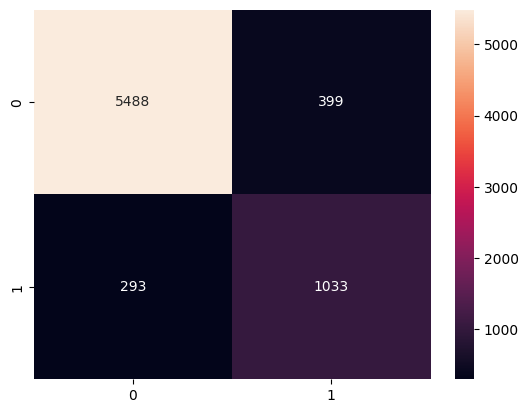

In [37]:
evaluate_model(lr,y_pred_lr)

In [38]:
dt=DecisionTreeClassifier()

In [39]:
dt.fit(x_train,y_train)

DecisionTreeClassifier()

In [40]:
y_pred_dt=dt.predict(x_test)

Accuracy Train Score : 1.0

Accuracy Test Score : 0.908359905725773

classification report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      5781
           1       0.77      0.77      0.77      1432

    accuracy                           0.91      7213
   macro avg       0.86      0.86      0.86      7213
weighted avg       0.91      0.91      0.91      7213



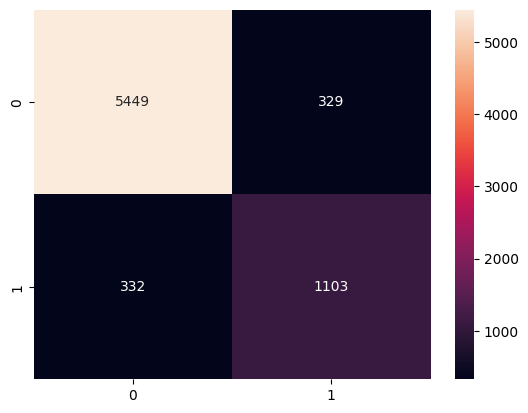

In [41]:
evaluate_model(dt,y_pred_dt)

In [42]:
rf=RandomForestClassifier(n_estimators=100)

In [43]:
rf.fit(x_train,y_train)

RandomForestClassifier()

In [44]:
y_pred_rf=rf.predict(x_test)

Accuracy Train Score : 1.0

Accuracy Test Score : 0.9286011368362679

classification report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      5781
           1       0.88      0.74      0.81      1432

    accuracy                           0.93      7213
   macro avg       0.91      0.86      0.88      7213
weighted avg       0.93      0.93      0.93      7213



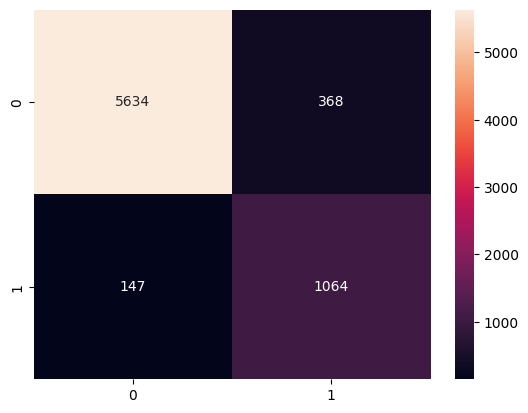

In [45]:
evaluate_model(rf,y_pred_rf)

In [46]:
svm=SVC()

In [47]:
svm.fit(x_train,y_train)

SVC()

In [48]:
y_pred_svm=svm.predict(x_test)

Accuracy Train Score : 0.9129003188687093

Accuracy Test Score : 0.9188964369887703

classification report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      5781
           1       0.83      0.74      0.78      1432

    accuracy                           0.92      7213
   macro avg       0.89      0.85      0.87      7213
weighted avg       0.92      0.92      0.92      7213



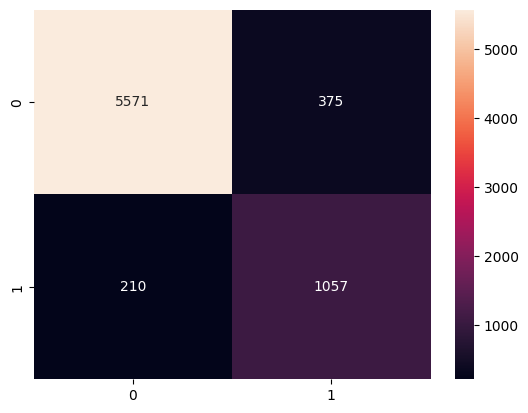

In [49]:
evaluate_model(svm,y_pred_svm)